## CSC 215 - Project 2
### Khoi Hoang
### William Dobson

In [1]:
import os
import csv
import json
import numpy as np
import pandas as pd
from scipy.stats import zscore
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn import metrics
from matplotlib.pyplot import figure, show
import matplotlib.pyplot as plt
%matplotlib inline
import collections
import sklearn.feature_extraction.text as sk_text

In [2]:
# Encode text values to dummy variables(i.e. [1,0,0],[0,1,0],[0,0,1] for red,green,blue)
def encode_text_dummy(df, name):
    dummies = pd.get_dummies(df[name])
    for x in dummies.columns:
        dummy_name = "{}-{}".format(name, x)
        df[dummy_name] = dummies[x]
    df.drop(name, axis=1, inplace=True)

# Encode text values to indexes(i.e. [1],[2],[3] for red,green,blue).
def encode_text_index(df, name):
    le = preprocessing.LabelEncoder()
    df[name] = le.fit_transform(df[name])
    return le.classes_

# Encode a numeric column as zscores
def encode_numeric_zscore(df, name, mean=None, sd=None):
    if mean is None:
        mean = df[name].mean()

    if sd is None:
        sd = df[name].std()

    df[name] = (df[name] - mean) / sd
    
# Convert all missing values in the specified column to the median
def missing_median(df, name):
    med = df[name].median()
    df[name] = df[name].fillna(med)    

# Regression chart.
def chart_regression(pred,y,sort=True):
    t = pd.DataFrame({'pred' : pred, 'y' : y.flatten()})
    if sort:
        t.sort_values(by=['y'],inplace=True)
    a = plt.plot(t['y'].tolist(),label='expected')
    b = plt.plot(t['pred'].tolist(),label='prediction')
    plt.ylabel('output')
    plt.legend()
    plt.show()    
    
# Convert a Pandas dataframe to the x,y inputs that TensorFlow needs
def to_xy(df, target):
    result = []
    for x in df.columns:
        if x != target:
            result.append(x)
    # find out the type of the target column. 
    target_type = df[target].dtypes
    target_type = target_type[0] if isinstance(target_type, collections.Sequence) else target_type
    # Encode to int for classification, float otherwise. TensorFlow likes 32 bits.
    if target_type in (np.int64, np.int32):
        # Classification
        dummies = pd.get_dummies(df[target])
        return df[result].values.astype(np.float32), dummies.values.astype(np.float32)
    else:
        # Regression
        return df[result].values.astype(np.float32), df[target].values.astype(np.float32)


### Convert JSON data into tabular format for Pandas

In [ ]:
#reviews.json
outfile = open("review_stars.tsv", 'w')
sfile = csv.writer(outfile, delimiter ="\t", quoting=csv.QUOTE_MINIMAL)
sfile.writerow(['business_id','stars', 'text'])
with open('review.json', encoding="utf8") as f:
    for line in f:
        row = json.loads(line)
        # some special char must be encoded in 'utf-8'
        sfile.writerow([row['business_id'], row['stars'], (row['text']).encode('utf-8')])

outfile.close()

In [ ]:
#business.json
outfile = open("business.tsv", 'w')
sfile = csv.writer(outfile, delimiter ="\t", quoting=csv.QUOTE_MINIMAL)
sfile.writerow(['business_id','stars', 'review_count', 'categories'])
with open('business.json', encoding="utf8") as f:
    for line in f:
        row = json.loads(line)
        # some special char must be encoded in 'utf-8'
        sfile.writerow([row['business_id'], row['stars'], row['review_count'], row['categories']])

outfile.close()

In [ ]:
#tip.json
outfile = open("tip.tsv", 'w')
sfile = csv.writer(outfile, delimiter ="\t", quoting=csv.QUOTE_MINIMAL)
sfile.writerow(['business_id','text'])
with open('tip.json', encoding="utf8") as f:
    for line in f:
        row = json.loads(line)
        # some special char must be encoded in 'utf-8'
        sfile.writerow([row['business_id'], (row['text']).encode('utf-8')])

outfile.close()

In [3]:
df_review= pd.read_csv('review_stars.tsv', delimiter ="\t", encoding="utf-8")
df_business= pd.read_csv('business.tsv', delimiter ="\t", encoding="utf-8")
df_tip= pd.read_csv('tip.tsv', delimiter ="\t", encoding="utf-8")
df_tip[0:5]

,business_id,text
0,VaKXUpmWTTWDKbpJ3aQdMw,"b'Great for watching games, ufc, and whatever ..."
1,OPiPeoJiv92rENwbq76orA,b'Happy Hour 2-4 daily with 1/2 price drinks a...
2,5KheTjYPu1HcQzQFtm4_vw,b'Good chips and salsa. Loud at times. Good se...
3,TkoyGi8J7YFjA6SbaRzrxg,b'The setting and decoration here is amazing. ...
4,AkL6Ous6A1atZejfZXn1Bg,b'Molly is definately taking a picture with Sa...


In [4]:
df_review.head()

,business_id,stars,text
0,ujmEBvifdJM6h6RLv4wQIg,1.0,b'Total bill for this horrible service? Over $...
1,NZnhc2sEQy3RmzKTZnqtwQ,5.0,"b""I *adore* Travis at the Hard Rock's new Kell..."
2,WTqjgwHlXbSFevF32_DJVw,5.0,"b""I have to say that this office really has it..."
3,ikCg8xy5JIg_NGPx-MSIDA,5.0,"b""Went in for a lunch. Steak sandwich was deli..."
4,b1b1eb3uo-w561D0ZfCEiQ,1.0,b'Today was my second out of three sessions I ...


In [5]:
#only consider reviews that have more than 50 characters
df_review = df_review[df_review['text'].str.len() >= 50]
df_review.shape

(6678404, 3)

In [6]:
df_tip = df_tip[df_tip['text'].str.len() >= 20]
df_tip.shape

(1094522, 2)

In [7]:
#group all reviews by each business and create a new dataframe, where each line is a business with all its reviews
df_review_agg = df_review.groupby('business_id')['text'].sum()

df_all_reviews = pd.DataFrame({'business_id': df_review_agg.index, 'all_reviews': df_review_agg.values})

In [8]:
#group all tip by each business and create a new dataframe, where each line is a business with all its tips
df_tip_agg = df_tip.groupby('business_id')['text'].sum()

df_all_tips = pd.DataFrame({'business_id': df_tip_agg.index, 'all_tips': df_tip_agg.values})

In [9]:
df_all_tips.head()

,business_id,all_tips
0,--1UhMGODdWsrMastO9DZw,"b""Delicious! One of the best burritos, salsa a..."
1,--6MefnULPED_I942VcFNA,b'BBQ pork is sold out early on Saturday'b'The...
2,--7zmmkVg-IMGaXbuVd0SQ,"b""Good place to stop when traffic don't go.""b'..."
3,--9QQLMTbFzLJ_oT-ON3Xw,"b""Tip? Don't get your hair cut here. If they'r..."
4,--9e1ONYQuAa-CB_Rrw7Tw,b'Wine pairings for my prix fixe meal. Mmmm'b...


#### Only consider businesses which have more than 20 reviews

In [10]:
df_business = df_business[df_business['review_count'] >= 20]
df_business.shape

(57644, 4)

In [11]:
#merge df_business, df_all_reviews, and df_all_tips by business_id
df_ready_for_sklearn = pd.merge(pd.merge(df_all_reviews, df_business, on='business_id', how='inner'), df_all_tips, on='business_id', how='inner')
#df_ready_for_sklearn = pd.merge(df_all_reviews, df_business, on='business_id', how='inner')
df_ready_for_sklearn.shape

(54657, 6)

In [12]:
df_ready_for_sklearn.isnull().any()

business_id     False
all_reviews     False
stars           False
review_count    False
categories       True
all_tips        False
dtype: bool

In [13]:
#label encode the stars
le = preprocessing.LabelEncoder()
df_ready_for_sklearn['encoded_stars'] = le.fit_transform(df_ready_for_sklearn['stars'])

In [14]:
print(df_ready_for_sklearn.shape)
df_ready_for_sklearn[0:5]

(54657, 7)


,business_id,all_reviews,stars,review_count,categories,all_tips,encoded_stars
0,--1UhMGODdWsrMastO9DZw,b'If you are looking for authentic Mexican str...,4.0,24,"Restaurants, Mexican","b""Delicious! One of the best burritos, salsa a...",6
1,--6MefnULPED_I942VcFNA,"b""They have the best Chinese BBQ Pork (Char Si...",3.0,44,"Chinese, Restaurants",b'BBQ pork is sold out early on Saturday'b'The...,4
2,--7zmmkVg-IMGaXbuVd0SQ,"b""I'm a tad reluctant to write a review as I r...",4.0,58,"Breweries, Food","b""Good place to stop when traffic don't go.""b'...",6
3,--9e1ONYQuAa-CB_Rrw7Tw,b'Very busy and noisy restaurant.\nAsparagas w...,4.0,1613,"Cajun/Creole, Seafood, Steakhouses, Restaurants",b'Wine pairings for my prix fixe meal. Mmmm'b...,6
4,--DaPTJW3-tB1vP-PfdTEg,b'My sister and in laws were in town and we wa...,3.5,49,"Restaurants, Breakfast & Brunch",b'Awesome. Huge portions definitely worth a v...,5


## Split the data and prepare for training and testing

In [15]:
x_train, x_test, y_train, y_test = train_test_split(df_ready_for_sklearn, df_ready_for_sklearn['stars'], test_size=0.25, random_state=43)

In [16]:
x_train['review_count_zscore'] = zscore(x_train['review_count'])
x_train[0:5]

C:\Users\hgdan\Anaconda3\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


,business_id,all_reviews,stars,review_count,categories,all_tips,encoded_stars,review_count_zscore
53526,ygcX18rboNOaYnNmRCDytw,b'I drive 45 minutes from Cleveland to enjoy t...,4.0,30,"Restaurants, Cafes, Tea Rooms, Bubble Tea, Food",b'cute shop and helpful staff!'b'The greatest ...,6,-0.374402
16481,IB_aESRBh2cmYWSF6Fv0jQ,b'I was really happy with Spencer\'s when I pu...,3.0,94,"Home & Garden, Shopping, Appliances, Electronics",b'Best pricing in town.Next day delivery great...,4,-0.021752
21744,OI_lS_aamMgjnHqNlaO2rA,"b""For a post office, this location is pretty g...",2.5,21,"Public Services & Government, Local Services, ...","b""Kinda old school. Feels weird. Have to Stand...",3,-0.423993
49426,tyQWsZUSoMuoX6_5pcCE8Q,"b""Honestly the worst latte I've ever had. Got ...",4.5,108,"Coffee & Tea, Coffee Roasteries, Food",b'Cute simple coffee shop. Great coffee and th...,7,0.055390
23280,Q7rrhu3FJxTASTo46pT9vA,"b""It tastes great and the atmosphere is great ...",3.5,101,"Coffee & Tea, Food",b'$3 cappuccino is a pretty sweet deal. I have...,5,0.016819


In [17]:
x_test['review_count_zscore'] = zscore(x_test['review_count'])
x_test[0:5]

C:\Users\hgdan\Anaconda3\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


,business_id,all_reviews,stars,review_count,categories,all_tips,encoded_stars,review_count_zscore
53763,yyiHkabQBtLifVTsO1r1kw,"b""I am not the biggest fan of Walmart but they...",3.0,37,"Food, Shopping, Grocery, Fashion, Drugstores, ...",b'Picking up some goodies for E.B.!'b'Rich wal...,4,-0.293785
50802,vZu12JAudoXBv3-i0JmSiQ,"b""I brought a watch strap in to get a few link...",3.0,29,"Shopping, Jewelry, Watch Repair, Local Service...",b'5 mins in and out for a battery replacement....,4,-0.330296
54033,zIpW3YlE9fFwyWOT5HGI6A,"b""Only giving one star cuz I have to. Terrible...",2.0,41,"Fast Food, Ice Cream & Frozen Yogurt, Restaura...","b""Get better employees and listen to what peop...",2,-0.275530
27076,UaL6yRGSv9fYCyn2DJLu8w,"b'Greek salad add avacado, very fresh very del...",4.5,42,"Food, Juice Bars & Smoothies, Restaurants, Cof...","b'Love this place. Good food, fresh as fuck ju...",7,-0.270966
14056,FML0YqZ7dLBBC3Suap4_4Q,"b""My favourite place in the city! Great vibe a...",4.0,296,"Nightlife, Restaurants, Tapas/Small Plates, Bars",b'Most of the food is made in house'b'All is g...,6,0.888237


In [18]:
#obtain tfidf score for reviews
vectorizer = sk_text.TfidfVectorizer(stop_words='english', max_features=250, min_df=0.05)

reviews_matrix_train = vectorizer.fit_transform(x_train['all_reviews'])
reviews_tfidf_train = reviews_matrix_train.toarray()

reviews_matrix_test = vectorizer.transform(x_test['all_reviews'])
reviews_tfidf_test = reviews_matrix_test.toarray()

vectorizer.get_feature_names()

['10',
 '15',
 '20',
 '30',
 'able',
 'absolutely',
 'actually',
 'amazing',
 'area',
 'ask',
 'asked',
 'atmosphere',
 'away',
 'awesome',
 'bad',
 'bar',
 'beef',
 'beer',
 'best',
 'better',
 'big',
 'bit',
 'bread',
 'breakfast',
 'burger',
 'business',
 'busy',
 'called',
 'came',
 'car',
 'care',
 'check',
 'cheese',
 'chicken',
 'clean',
 'coffee',
 'come',
 'coming',
 'cooked',
 'cool',
 'couldn',
 'couple',
 'cream',
 'customer',
 'day',
 'decent',
 'decided',
 'definitely',
 'delicious',
 'dessert',
 'did',
 'didn',
 'different',
 'dinner',
 'disappointed',
 'dish',
 'dishes',
 'don',
 'drink',
 'drinks',
 'eat',
 'eating',
 'end',
 'enjoy',
 'enjoyed',
 'especially',
 'excellent',
 'experience',
 'extra',
 'family',
 'fantastic',
 'far',
 'fast',
 'favorite',
 'feel',
 'felt',
 'finally',
 'fish',
 'flavor',
 'food',
 'free',
 'fresh',
 'fried',
 'friend',
 'friendly',
 'friends',
 'fries',
 'fun',
 'gave',
 'getting',
 'going',
 'good',
 'got',
 'great',
 'half',
 'happy',


In [19]:
y_train.head()

53526    4.0
16481    3.0
21744    2.5
49426    4.5
23280    3.5
Name: stars, dtype: float64

In [20]:
#obtain tfidf score for tips
vectorizer = sk_text.TfidfVectorizer(stop_words='english', max_features=250, min_df=0.05)

tips_matrix_train = vectorizer.fit_transform(x_train['all_tips'])
tips_tfidf_train = tips_matrix_train.toarray()

tips_matrix_test = vectorizer.transform(x_test['all_tips'])
tips_tfidf_test = tips_matrix_test.toarray()

vectorizer.get_feature_names()

['10',
 '11',
 '15',
 '20',
 '30',
 '50',
 '99',
 'absolutely',
 'amazing',
 'area',
 'ask',
 'atmosphere',
 'authentic',
 'available',
 'away',
 'awesome',
 'bad',
 'bar',
 'beautiful',
 'beef',
 'beer',
 'best',
 'better',
 'big',
 'bit',
 'bomb',
 'bread',
 'breakfast',
 'bring',
 'burger',
 'business',
 'busy',
 'buy',
 'came',
 'card',
 'cash',
 'cheap',
 'check',
 'cheese',
 'chicken',
 'chocolate',
 'clean',
 'close',
 'closed',
 'coffee',
 'cold',
 'come',
 'coming',
 'cool',
 'cream',
 'customer',
 'day',
 'deal',
 'decent',
 'definitely',
 'delicious',
 'did',
 'didn',
 'different',
 'dinner',
 'disappointed',
 'does',
 'don',
 'drink',
 'drinks',
 'drive',
 'early',
 'eat',
 'enjoy',
 'excellent',
 'experience',
 'extra',
 'family',
 'fantastic',
 'far',
 'fast',
 'favorite',
 'feel',
 'fish',
 'flavor',
 'food',
 'free',
 'fresh',
 'friday',
 'fried',
 'friendly',
 'friends',
 'fries',
 'fun',
 'getting',
 'going',
 'good',
 'got',
 'great',
 'green',
 'guys',
 'half',
 'ha

In [21]:
temp = x_train['review_count_zscore'].values
input_data_train = np.column_stack((reviews_tfidf_train, tips_tfidf_train))
input_data_train = np.column_stack((input_data_train, temp))
#input_data_train = np.column_stack((reviews_tfidf_train, temp))
#input_data_train.shape

temp = x_test['review_count_zscore'].values
input_data_test = np.column_stack((reviews_tfidf_test, tips_tfidf_test))
input_data_test = np.column_stack((input_data_test, temp))
#input_data_test = np.column_stack((reviews_tfidf_test, temp))
input_data_test.shape

(13665, 501)

In [22]:
type(input_data_train)

numpy.ndarray

In [23]:
#convert into dataframe
df_train = pd.DataFrame(input_data_train)
df_test = pd.DataFrame(input_data_test)
df_train['stars'] = y_train.values
df_test['stars'] = y_test.values
#df_train.dropna()
#missing_median(df_train, 'stars')
#missing_median(df_test, 'stars')

In [24]:
df_test.isnull().values.any()

False

In [25]:
df_train.shape

(40992, 502)

In [26]:
x_train_tf,y_train_tf = to_xy(df_train,'stars')

In [27]:
x_test_tf,y_test_tf = to_xy(df_test,'stars')

In [28]:
y_train_tf

array([4. , 3. , 2.5, ..., 3.5, 4. , 4. ], dtype=float32)

# Tensorflow

### Regression model

In [29]:
from keras.models import Sequential
from keras.layers.core import Dense, Activation
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
from keras import optimizers

Using TensorFlow backend.


In [30]:
model = Sequential()

model.add(Dense(100, input_dim=x_train_tf.shape[1], activation='relu')) # Hidden 1     #  why input_dim=x.shape[1]?  
model.add(Dense(200, activation='relu')) # Hidden 2
model.add(Dense(300, activation='relu')) # Hidden 3
model.add(Dense(200, activation='relu')) # Hidden 4
model.add(Dense(1)) # Output

model.compile(loss='mean_squared_error', optimizer='adam')

monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=1, mode='auto')
checkpointer = ModelCheckpoint(filepath=".\lowest_error.hdf5", verbose=0, save_best_only=True) # save best model


model.fit(x_train_tf,y_train_tf, validation_data=(x_test_tf,y_test_tf), callbacks=[monitor,checkpointer],verbose=2,epochs=1000)    # Verbosity mode. 0 = silent, 1 = progress bar, 2 = one line per epoch.


Train on 40992 samples, validate on 13665 samples
Epoch 1/1000
 - 8s - loss: 0.2618 - val_loss: 0.1161
Epoch 2/1000
 - 4s - loss: 0.1045 - val_loss: 0.1087
Epoch 3/1000
 - 4s - loss: 0.0914 - val_loss: 0.1040
Epoch 4/1000
 - 4s - loss: 0.0841 - val_loss: 0.1053
Epoch 5/1000
 - 4s - loss: 0.0777 - val_loss: 0.0983
Epoch 6/1000
 - 4s - loss: 0.0722 - val_loss: 0.0963
Epoch 7/1000
 - 4s - loss: 0.0668 - val_loss: 0.0945
Epoch 8/1000
 - 4s - loss: 0.0606 - val_loss: 0.0970
Epoch 9/1000
 - 4s - loss: 0.0562 - val_loss: 0.0985
Epoch 10/1000
 - 4s - loss: 0.0514 - val_loss: 0.1149
Epoch 11/1000
 - 4s - loss: 0.0480 - val_loss: 0.1102
Epoch 12/1000
 - 4s - loss: 0.0446 - val_loss: 0.1121
Epoch 00012: early stopping


In [31]:
pred = model.predict(x_test_tf)
print("Shape: {}".format(pred.shape))
print(pred)

Shape: (13665, 1)
[[2.4145038]
 [3.641838 ]
 [2.946934 ]
 ...
 [4.012273 ]
 [4.351688 ]
 [2.116729 ]]


In [32]:
score = np.sqrt(metrics.mean_squared_error(pred,y_test_tf))
print("Final score (RMSE): {}".format(score))

Final score (RMSE): 0.33479273319244385


In [33]:
y_test_tf.shape

(13665,)

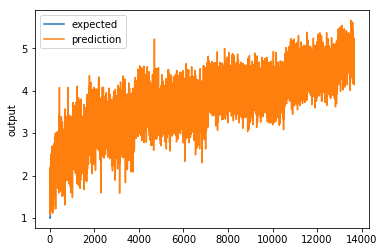

In [34]:
# Plot the chart
chart_regression(pred.flatten(),y_test_tf)

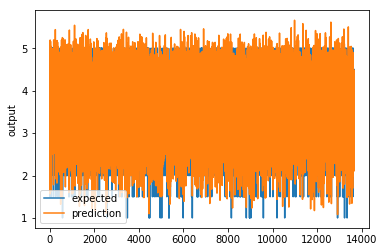

In [35]:
chart_regression(pred.flatten(),y_test_tf, sort=False)

### Tensorflow Classification

In [44]:
y_oneHotEncode = pd.get_dummies(df_ready_for_sklearn['stars'])
type(y_oneHotEncode)

pandas.core.frame.DataFrame

In [45]:
x_train, x_test, y_train, y_test = train_test_split(df_ready_for_sklearn, y_oneHotEncode, test_size=0.25, random_state=43)

In [51]:
x_train['review_count_zscore'] = zscore(x_train['review_count'])
x_train[0:5]

C:\Users\hgdan\Anaconda3\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


,business_id,all_reviews,stars,review_count,categories,all_tips,encoded_stars,review_count_zscore
53526,ygcX18rboNOaYnNmRCDytw,b'I drive 45 minutes from Cleveland to enjoy t...,4.0,30,"Restaurants, Cafes, Tea Rooms, Bubble Tea, Food",b'cute shop and helpful staff!'b'The greatest ...,6,-0.374402
16481,IB_aESRBh2cmYWSF6Fv0jQ,b'I was really happy with Spencer\'s when I pu...,3.0,94,"Home & Garden, Shopping, Appliances, Electronics",b'Best pricing in town.Next day delivery great...,4,-0.021752
21744,OI_lS_aamMgjnHqNlaO2rA,"b""For a post office, this location is pretty g...",2.5,21,"Public Services & Government, Local Services, ...","b""Kinda old school. Feels weird. Have to Stand...",3,-0.423993
49426,tyQWsZUSoMuoX6_5pcCE8Q,"b""Honestly the worst latte I've ever had. Got ...",4.5,108,"Coffee & Tea, Coffee Roasteries, Food",b'Cute simple coffee shop. Great coffee and th...,7,0.055390
23280,Q7rrhu3FJxTASTo46pT9vA,"b""It tastes great and the atmosphere is great ...",3.5,101,"Coffee & Tea, Food",b'$3 cappuccino is a pretty sweet deal. I have...,5,0.016819


In [52]:
x_test['review_count_zscore'] = zscore(x_test['review_count'])
x_test[0:5]

C:\Users\hgdan\Anaconda3\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


,business_id,all_reviews,stars,review_count,categories,all_tips,encoded_stars,review_count_zscore
53763,yyiHkabQBtLifVTsO1r1kw,"b""I am not the biggest fan of Walmart but they...",3.0,37,"Food, Shopping, Grocery, Fashion, Drugstores, ...",b'Picking up some goodies for E.B.!'b'Rich wal...,4,-0.293785
50802,vZu12JAudoXBv3-i0JmSiQ,"b""I brought a watch strap in to get a few link...",3.0,29,"Shopping, Jewelry, Watch Repair, Local Service...",b'5 mins in and out for a battery replacement....,4,-0.330296
54033,zIpW3YlE9fFwyWOT5HGI6A,"b""Only giving one star cuz I have to. Terrible...",2.0,41,"Fast Food, Ice Cream & Frozen Yogurt, Restaura...","b""Get better employees and listen to what peop...",2,-0.275530
27076,UaL6yRGSv9fYCyn2DJLu8w,"b'Greek salad add avacado, very fresh very del...",4.5,42,"Food, Juice Bars & Smoothies, Restaurants, Cof...","b'Love this place. Good food, fresh as fuck ju...",7,-0.270966
14056,FML0YqZ7dLBBC3Suap4_4Q,"b""My favourite place in the city! Great vibe a...",4.0,296,"Nightlife, Restaurants, Tapas/Small Plates, Bars",b'Most of the food is made in house'b'All is g...,6,0.888237


In [53]:
#obtain tfidf score for reviews
vectorizer = sk_text.TfidfVectorizer(stop_words='english', max_features=250, min_df=0.05)

reviews_matrix_train = vectorizer.fit_transform(x_train['all_reviews'])
reviews_tfidf_train = reviews_matrix_train.toarray()

reviews_matrix_test = vectorizer.transform(x_test['all_reviews'])
reviews_tfidf_test = reviews_matrix_test.toarray()

vectorizer.get_feature_names()

['10',
 '15',
 '20',
 '30',
 'able',
 'absolutely',
 'actually',
 'amazing',
 'area',
 'ask',
 'asked',
 'atmosphere',
 'away',
 'awesome',
 'bad',
 'bar',
 'beef',
 'beer',
 'best',
 'better',
 'big',
 'bit',
 'bread',
 'breakfast',
 'burger',
 'business',
 'busy',
 'called',
 'came',
 'car',
 'care',
 'check',
 'cheese',
 'chicken',
 'clean',
 'coffee',
 'come',
 'coming',
 'cooked',
 'cool',
 'couldn',
 'couple',
 'cream',
 'customer',
 'day',
 'decent',
 'decided',
 'definitely',
 'delicious',
 'dessert',
 'did',
 'didn',
 'different',
 'dinner',
 'disappointed',
 'dish',
 'dishes',
 'don',
 'drink',
 'drinks',
 'eat',
 'eating',
 'end',
 'enjoy',
 'enjoyed',
 'especially',
 'excellent',
 'experience',
 'extra',
 'family',
 'fantastic',
 'far',
 'fast',
 'favorite',
 'feel',
 'felt',
 'finally',
 'fish',
 'flavor',
 'food',
 'free',
 'fresh',
 'fried',
 'friend',
 'friendly',
 'friends',
 'fries',
 'fun',
 'gave',
 'getting',
 'going',
 'good',
 'got',
 'great',
 'half',
 'happy',


In [54]:
#obtain tfidf score for tips
vectorizer = sk_text.TfidfVectorizer(stop_words='english', max_features=250, min_df=0.05)

tips_matrix_train = vectorizer.fit_transform(x_train['all_tips'])
tips_tfidf_train = tips_matrix_train.toarray()

tips_matrix_test = vectorizer.transform(x_test['all_tips'])
tips_tfidf_test = tips_matrix_test.toarray()

vectorizer.get_feature_names()

['10',
 '11',
 '15',
 '20',
 '30',
 '50',
 '99',
 'absolutely',
 'amazing',
 'area',
 'ask',
 'atmosphere',
 'authentic',
 'available',
 'away',
 'awesome',
 'bad',
 'bar',
 'beautiful',
 'beef',
 'beer',
 'best',
 'better',
 'big',
 'bit',
 'bomb',
 'bread',
 'breakfast',
 'bring',
 'burger',
 'business',
 'busy',
 'buy',
 'came',
 'card',
 'cash',
 'cheap',
 'check',
 'cheese',
 'chicken',
 'chocolate',
 'clean',
 'close',
 'closed',
 'coffee',
 'cold',
 'come',
 'coming',
 'cool',
 'cream',
 'customer',
 'day',
 'deal',
 'decent',
 'definitely',
 'delicious',
 'did',
 'didn',
 'different',
 'dinner',
 'disappointed',
 'does',
 'don',
 'drink',
 'drinks',
 'drive',
 'early',
 'eat',
 'enjoy',
 'excellent',
 'experience',
 'extra',
 'family',
 'fantastic',
 'far',
 'fast',
 'favorite',
 'feel',
 'fish',
 'flavor',
 'food',
 'free',
 'fresh',
 'friday',
 'fried',
 'friendly',
 'friends',
 'fries',
 'fun',
 'getting',
 'going',
 'good',
 'got',
 'great',
 'green',
 'guys',
 'half',
 'ha

In [55]:
temp = x_train['review_count_zscore'].values
input_data_train = np.column_stack((reviews_tfidf_train, tips_tfidf_train))
input_data_train = np.column_stack((input_data_train, temp))
#input_data_train = np.column_stack((reviews_tfidf_train, temp))
#input_data_train.shape

temp = x_test['review_count_zscore'].values
input_data_test = np.column_stack((reviews_tfidf_test, tips_tfidf_test))
input_data_test = np.column_stack((input_data_test, temp))
#input_data_test = np.column_stack((reviews_tfidf_test, temp))
input_data_test.shape

(13665, 501)

In [58]:
type(input_data_train)

numpy.ndarray

In [82]:
#convert into dataframe
df_train = pd.DataFrame(input_data_train)
df_test = pd.DataFrame(input_data_test)
#df_train['stars'] = y_train.values
#df_test['stars'] = y_test.values
#df_train.dropna()
#missing_median(df_train, 'stars')
#missing_median(df_test, 'stars')

In [83]:
df_train.reset_index(drop=True, inplace=True)
y_train.reset_index(drop=True, inplace=True)
df_train = pd.concat([df_train, y_train], axis=1)

df_test.reset_index(drop=True, inplace=True)
y_test.reset_index(drop=True, inplace=True)
df_test = pd.concat([df_test, y_test], axis=1)
df_test

,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,...,500.0,1.0,1.5,2.0,2.5,3.0,3.5,4.0,4.5,5.0
0,0.000000,0.037879,0.018500,0.018614,0.000000,0.018314,0.050536,0.016097,0.032276,0.136724,...,-0.293785,0,0,0,0,1,0,0,0,0
1,0.175102,0.022689,0.066485,0.089193,0.044504,0.021939,0.000000,0.000000,0.000000,0.000000,...,-0.330296,0,0,0,0,1,0,0,0,0
2,0.061999,0.028920,0.028249,0.014211,0.000000,0.013982,0.012861,0.024580,0.000000,0.039145,...,-0.275530,0,0,1,0,0,0,0,0,0
3,0.027662,0.016129,0.000000,0.000000,0.000000,0.000000,0.000000,0.137085,0.013743,0.029109,...,-0.270966,0,0,0,0,0,0,0,1,0
4,0.017931,0.005809,0.020425,0.019410,0.013673,0.012357,0.016532,0.046407,0.013858,0.018869,...,0.888237,0,0,0,0,0,0,1,0,0
5,0.038220,0.000000,0.010884,0.000000,0.021857,0.043098,0.019821,0.127852,0.014242,0.020110,...,0.158030,0,0,0,0,0,0,1,0,0
6,0.000000,0.000000,0.018563,0.000000,0.000000,0.000000,0.050710,0.000000,0.032387,0.034299,...,-0.371370,0,0,0,0,0,1,0,0,0
7,0.007831,0.009133,0.000000,0.000000,0.000000,0.035323,0.000000,0.054334,0.093379,0.008241,...,-0.275530,0,0,0,0,0,0,0,1,0
8,0.003235,0.011319,0.007371,0.007416,0.003701,0.003648,0.000000,0.012827,0.009645,0.023833,...,-0.179691,0,0,0,0,1,0,0,0,0
9,0.008298,0.009677,0.018904,0.009510,0.004745,0.009357,0.000000,0.024674,0.041227,0.017464,...,-0.019958,0,0,0,0,0,0,0,1,0


In [85]:
x_train_tf,y_train_tf = to_xy(df_train,y_train)

ValueError: The truth value of a DataFrame is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().

In [27]:
x_test_tf,y_test_tf = to_xy(df_test,'stars')

# Linear Regression

Preparing data for training/testing

In [ ]:
#Merge reviews_tfidf, tips_tfidf and review_count into one array for input
temp = df_ready_for_sklearn['review_count_zscore'].values
input_data = np.column_stack((reviews_tfidf, tips_tfidf))
input_data = np.column_stack((input_data, temp))
input_data.shape

In [ ]:
#split into train/test data
x_train, x_test, y_train, y_test = train_test_split(input_data, df_ready_for_sklearn['stars'], test_size=0.25, random_state=43)

In [ ]:
test_data = input_data[test_loc[0]]
for i in range(1, len(test_loc)):
    test_data = np.append(test_data, input_data[test_loc[i]], axis=0)
test_data.shape

In [ ]:
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

In [ ]:
from sklearn.linear_model import LinearRegression

# instantiate the model (using the default parameters)
linreg = LinearRegression()

# fit the model with data
linreg.fit(x_train, y_train)

# predict the response for new observations
y_pred_Linear = linreg.predict(test_data)

In [ ]:
print("Prediction result: ")
print("Business ID                         Categories             Predicted Star Rating         True Star Rating")
for i in range(5):
    print("{:.20}             {:.23}         {:.5}                         {}".format(test_businesses[i]['business_id'], test_businesses[i]['categories'], y_pred_Linear[i], test_true_stars[i]))

### Support Vector Machine

In [ ]:
#split into train/test data
#using encoded stars because classification problem
x_train, x_test, y_train, y_test = train_test_split(input_data, df_ready_for_sklearn['encoded_stars'], test_size=0.25, random_state=43)

In [ ]:
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

In [ ]:
from sklearn.svm import LinearSVC

clf = LinearSVC(dual=False)
clf.fit(x_train, y_train)

y_pred_SVM = clf.predict(test_data)

In [ ]:
y_pred_SVM = le.inverse_transform(y_pred_SVM)
print("Prediction result: ")
print("Business ID                         Categories             Predicted Star Rating         True Star Rating")
for i in range(5):
    print("{:.20}             {:.23}         {:.5}                         {}".format(test_businesses[i]['business_id'], test_businesses[i]['categories'], y_pred_SVM[i], test_true_stars[i]))

### Logistic Regression

In [ ]:
from sklearn.linear_model import LogisticRegression

# instantiate the model (using the default parameters)
logreg = LogisticRegression()

# fit the model with data
logreg.fit(x_train, y_train)

# predict the response for new observations
y_pred_Logistic = logreg.predict(test_data)

In [ ]:
y_pred_Logistic = le.inverse_transform(y_pred_Logistic)
print("Prediction result: ")
print("Business ID                         Categories             Predicted Star Rating         True Star Rating")
for i in range(5):
    print("{:.20}             {:.23}         {:.5}                         {}".format(test_businesses[i]['business_id'], test_businesses[i]['categories'], y_pred_Logistic[i], test_true_stars[i]))

### Nearest Neighbor

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

# instantiate the model (using the value K=10)
knn = KNeighborsClassifier(n_neighbors=10)

# fit the model with data
knn.fit(x_train, y_train)

In [ ]:
# predict the response for new observations
y_neighbor = knn.predict(test_data)

In [ ]:
y_neighbor = le.inverse_transform(y_neighbor)
print("Prediction result: ")
print("Business ID                         Categories             Predicted Star Rating         True Star Rating")
for i in range(5):
    print("{:.20}             {:.23}         {:.5}                         {}".format(test_businesses[i]['business_id'], test_businesses[i]['categories'], y_neighbor[i], test_true_stars[i]))

### Multinomial Naive Bayes

In [ ]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

temp = scaler.fit_transform(df_ready_for_sklearn['review_count'].values.reshape(1, -1))

input_data_MNB = np.column_stack((reviews_tfidf, tips_tfidf))
input_data_MNB = np.column_stack((input_data_MNB, temp.reshape(-1,1)))

input_data_MNB

In [ ]:
test_data = input_data_MNB[test_loc[0]]
for i in range(1, len(test_loc)):
    test_data = np.append(test_data, input_data_MNB[test_loc[i]], axis=0)
test_data.shape

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(input_data_MNB, df_ready_for_sklearn['encoded_stars'], test_size=0.25, random_state=43)

In [ ]:
from sklearn.naive_bayes import MultinomialNB

# instantiate the model (using the default parameters)
mnb = MultinomialNB()

# fit the model with data
mnb.fit(x_train, y_train)

# predict the response for new observations
y_mnb = mnb.predict(test_data)

In [ ]:
y_mnb = le.inverse_transform(y_mnb)
print("Prediction result: ")
print("Business ID                         Categories             Predicted Star Rating         True Star Rating")
for i in range(5):
    print("{:.20}             {:.23}         {:.5}                         {}".format(test_businesses[i]['business_id'], test_businesses[i]['categories'], y_mnb[i], test_true_stars[i]))